In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from typing import Optional, Tuple, Union


In [2]:
import sys
sys.path.append('..')


In [3]:
from dem.energies.gmm_energy import GMM

In [4]:
gmm_dist=GMM(
        plotting_buffer_sample_size=1000,
        should_unnormalize=False,
        data_normalization_factor=1,
        train_set_size=1000,
        test_set_size=1000,
        val_set_size=1000)

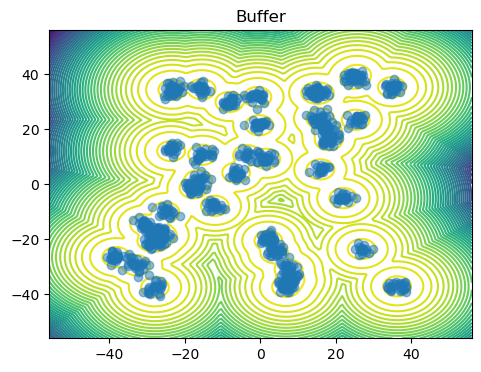

In [6]:
true_samples=gmm_dist.gmm.sample((1000,))

#plot the samples
fig=gmm_dist.get_dataset_fig(true_samples)
true_samples=true_samples.unsqueeze(1)



In [7]:
def _calc_dist_total_var(
    gt_samples: torch.Tensor,
    latest_samples: torch.Tensor,
    system_shape: Union[torch.Size, Tuple[int]],
    energy_function    ) -> torch.Tensor:
    x = gt_samples.view(*system_shape)
    y = latest_samples.view(*system_shape) if latest_samples.device == "cpu" else latest_samples.detach().cpu().view(*system_shape)
    
    if x.size(-1) == 3:
        generated_samples_dists = (
            energy_function.interatomic_dist(x).cpu().numpy().reshape(-1),
        )
        data_set_dists = energy_function.interatomic_dist(y).cpu().numpy().reshape(-1)

        H_data_set, x_data_set = torch.histogram(data_set_dists, bins=200)
        H_generated_samples, _ = torch.histogram(generated_samples_dists, bins=(x_data_set))
        total_var = (
            0.5
            * torch.abs(
                H_data_set / H_data_set.sum() - H_generated_samples / H_generated_samples.sum()
            ).sum()
        )
    else:
        H_data_set_x, x_data_set = torch.histogram(x[:, 0], bins=200)
        H_data_set_y, _ = torch.histogram(x[:, 1], bins=(x_data_set))
        H_generated_samples_x, _ = torch.histogram(y[:, 0], bins=(x_data_set))
        H_generated_samples_y, _ = torch.histogram(y[:, 1], bins=(x_data_set))
        total_var = (
            0.5
            * (
                torch.abs(
                    H_data_set_x / H_data_set_x.sum() - H_generated_samples_x / H_generated_samples_x.sum()
                ) +
                torch.abs(
                    H_data_set_y / H_data_set_y.sum() - H_generated_samples_y / H_generated_samples_y.sum()
                )
            ).sum()
        )
    return total_var

Ideal W2 and total variation scores

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


w2 mean 4.18674830327235 w2 std 0.6294568869042068
tv mean 0.4753966850042343 tv std 0.0186410447793573


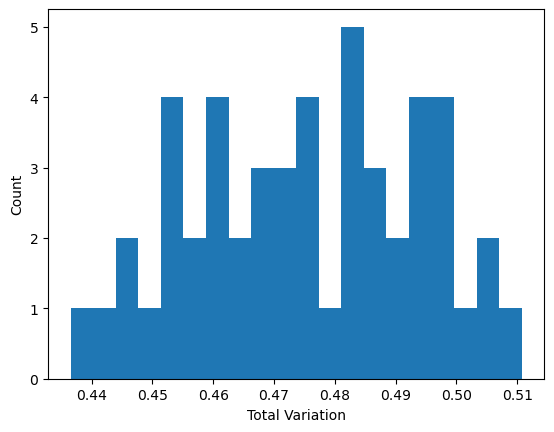

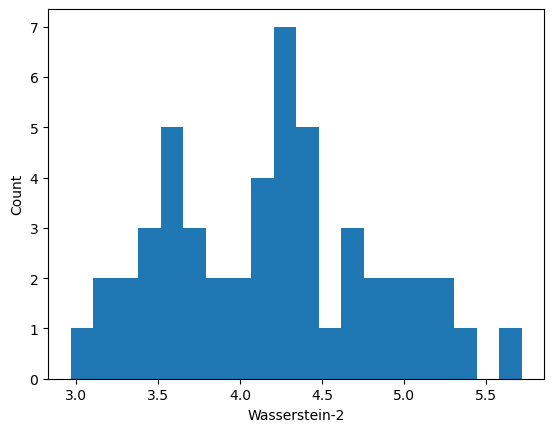

In [8]:
from dem.models.components.distribution_distances import compute_distribution_distances

tv_list=[]
w2_list=[]
for i in tqdm.tqdm(range(50)):
    new_samples=gmm_dist.gmm.sample((1000,))
    tv=_calc_dist_total_var(true_samples[:,0,:],new_samples,new_samples.shape,gmm_dist)
    new_samples=new_samples.unsqueeze(1)
    metrics=compute_distribution_distances(true_samples,new_samples,gmm_dist)
    w2=metrics[1][1]
    tv_list.append(tv.item())
    w2_list.append(w2)

plt.figure()
plt.hist(tv_list,label='Total Variation',bins=20)
plt.ylabel('Count')
plt.xlabel('Total Variation')
plt.figure()
plt.hist(w2_list,label='Wasserstein-2',bins=20)
plt.ylabel('Count')
plt.xlabel('Wasserstein-2')
print('w2 mean',np.mean(w2_list),'w2 std',np.std(w2_list))
print('tv mean',np.mean(tv_list),'tv std',np.std(tv_list))

Calculating the best alpha*sigma possible to determine the MCMC step size

In [10]:
from torch.distributions import MultivariateNormal

def metropolis_acceptance(energy_function, x_new, x):
    return torch.exp(energy_function(x_new) - energy_function(x)) >torch.rand(1)

def metropolis_hastings_acceptance(energy_function,x_new,x,std,step_size):
    x_new=x_new.requires_grad_(True)
    energies=energy_function(x_new)
    energy_grads=torch.autograd.grad(energies.sum(),x_new)[0]
    x_given_x_new_mean=x_new+energy_grads*step_size*((std**2)/2)
    energies=gmm_dist(x)
    energy_grads=torch.autograd.grad(energies.sum(),x)[0]
    x_new_given_x_mean=x+energy_grads*step_size*((std**2)/2)
    logprob_x_new_given_x=MultivariateNormal(x_new_given_x_mean,(std**2)*torch.eye(x_new.shape[-1])*step_size).log_prob(x_new)
    logprob_x_given_x_new=MultivariateNormal(x_given_x_new_mean,(std**2)*torch.eye(x_new.shape[-1])*step_size).log_prob(x)
    metro_prob= torch.exp(energy_function(x_new) - energy_function(x) + logprob_x_given_x_new - logprob_x_new_given_x)
    return metro_prob>torch.rand(1)
    

    

In [ ]:


true_samples=gmm_dist.gmm.sample((1000,))
normal_dist=MultivariateNormal(torch.zeros(true_samples.shape[-1]),torch.eye(true_samples.shape[-1]))
std_dev_list=[1,0.1,0.01,0.001]
for std in std_dev_list:
    print('std',std)
    inital_samples=(torch.rand_like(true_samples)*2-1)*45
    acceptance_rate=[]
    for i in tqdm.tqdm(range(10000)):
        new_samples=inital_samples+torch.randn_like(inital_samples)*std
        acceptances=metropolis_acceptance(gmm_dist,new_samples,inital_samples)
        acceptance_rate.append(metropolis_acceptance(gmm_dist,new_samples,inital_samples).sum()/len(new_samples))
        inital_samples[acceptances]=new_samples[acceptances]
    acceptance_rate=acceptance_rate[2000:]
    print('acceptance rate',np.mean(acceptance_rate))
    

std 1


 10%|▉         | 989/10000 [00:09<01:27, 102.52it/s]


KeyboardInterrupt: 

In [ ]:
std_dev_list=[0.5,2.5]

for std in std_dev_list:
    print('std',std)
    inital_samples=(torch.rand_like(true_samples)*2-1)*45
    acceptance_rate=[]
    for i in tqdm.tqdm(range(10000)):
        new_samples=inital_samples+torch.randn_like(inital_samples)*std
        acceptances=metropolis_acceptance(gmm_dist,new_samples,inital_samples)
        acceptance_rate.append(metropolis_acceptance(gmm_dist,new_samples,inital_samples).sum()/len(new_samples))
        inital_samples[acceptances]=new_samples[acceptances]
    acceptance_rate=acceptance_rate[2000:]
    print('acceptance rate',np.mean(acceptance_rate))

std 0.5


100%|██████████| 10000/10000 [01:09<00:00, 143.28it/s]


acceptance rate 0.8224187
std 2.5


100%|██████████| 10000/10000 [01:08<00:00, 145.59it/s]


acceptance rate 0.37077487


In [ ]:
std_dev_list=[1.5]

for std in std_dev_list:
    print('std',std)
    inital_samples=(torch.rand_like(true_samples)*2-1)*45
    acceptance_rate=[]
    for i in tqdm.tqdm(range(10000)):
        new_samples=inital_samples+torch.randn_like(inital_samples)*std
        acceptances=metropolis_acceptance(gmm_dist,new_samples,inital_samples)
        acceptance_rate.append(metropolis_acceptance(gmm_dist,new_samples,inital_samples).sum()/len(new_samples))
        inital_samples[acceptances]=new_samples[acceptances]
    acceptance_rate=acceptance_rate[2000:]
    print('acceptance rate',np.mean(acceptance_rate))

std 1.5


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:09<00:00, 143.71it/s]


acceptance rate 0.53929305


In [ ]:
step_size_list=[1,0.5,0.1]
std=1.5
for step_size in step_size_list:
    print('step_size',step_size)
    inital_samples=(torch.rand_like(true_samples)*2-1)*45
    new_samples=inital_samples
    new_samples.requires_grad_(True)
    acceptance_rate=[]
    for i in tqdm.tqdm(range(10000)):
        energies=gmm_dist(new_samples)
        energy_grads=torch.autograd.grad(energies.sum(),new_samples)[0]
        with torch.no_grad():
            new_new_samples=new_samples + ((std**2)/2)*energy_grads*step_size+torch.randn_like(inital_samples)*std*(step_size**0.5)
        acceptances=metropolis_hastings_acceptance(gmm_dist,new_new_samples,new_samples,std,step_size)
        acceptance_rate.append(acceptances.sum()/len(new_samples))
        new_samples=new_new_samples.requires_grad_(True)
    acceptance_rate=acceptance_rate[2000:]
    print('acceptance rate',np.mean(acceptance_rate))

step_size 1


100%|██████████| 10000/10000 [01:57<00:00, 85.30it/s]


acceptance rate 0.8495749
step_size 0.5


100%|██████████| 10000/10000 [01:54<00:00, 87.45it/s]


acceptance rate 0.9379488
step_size 0.1


100%|██████████| 10000/10000 [01:41<00:00, 98.48it/s]

acceptance rate 0.9943142


In [ ]:
step_size_list=[0.05,0.01,0.005]
std=1.5
for step_size in step_size_list:
    print('step_size',step_size)
    inital_samples=(torch.rand_like(true_samples)*2-1)*45
    new_samples=inital_samples
    new_samples.requires_grad_(True)
    acceptance_rate=[]
    for i in tqdm.tqdm(range(10000)):
        energies=gmm_dist(new_samples)
        energy_grads=torch.autograd.grad(energies.sum(),new_samples)[0]
        with torch.no_grad():
            new_samples=new_samples + ((std**2)/2)*energy_grads*step_size+torch.randn_like(inital_samples)*std*(step_size**0.5)
        acceptances=metropolis_hastings_acceptance(gmm_dist,new_samples,inital_samples,std,step_size)
        acceptance_rate.append(acceptances.sum()/len(new_samples))
        new_samples.requires_grad_(True)
    acceptance_rate=acceptance_rate[2000:]
    print('acceptance rate',np.mean(acceptance_rate))

step_size 0.05


100%|██████████| 10000/10000 [01:58<00:00, 84.44it/s]


acceptance rate 0.9999313
step_size 0.01


100%|██████████| 10000/10000 [01:57<00:00, 84.95it/s]


acceptance rate 0.9999943
step_size 0.005


100%|██████████| 10000/10000 [01:58<00:00, 84.50it/s]

acceptance rate 0.99999315


Naive ultra long MC chain

In [15]:
true_samples=gmm_dist.gmm.sample((1000,))

inital_samples=(torch.rand_like(true_samples)*2-1)*45
true_samples=true_samples.unsqueeze(1)
std=1.5
w2_list=[]
for i in tqdm.tqdm(range(1000000)):
    new_samples=inital_samples+torch.randn_like(inital_samples)*std
    acceptances=metropolis_acceptance(gmm_dist,new_samples,inital_samples)
    inital_samples[acceptances]=new_samples[acceptances]
    if i%250==0:
        current_samples=inital_samples.unsqueeze(1)
        metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
        w2=metrics[1][1]
        w2_list.append(w2)
plt.figure()
plt.plot(w2_list)

 66%|██████▋   | 664061/1000000 [1:00:16<30:29, 183.63it/s]


KeyboardInterrupt: 

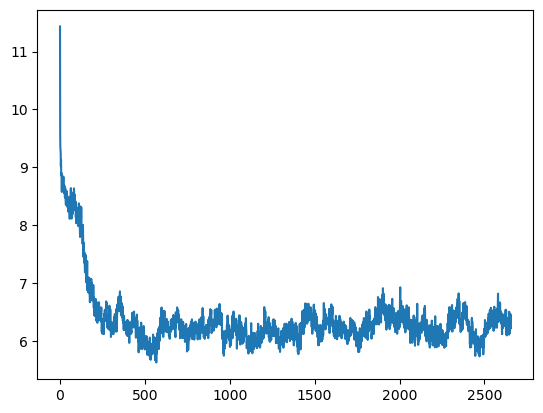

In [16]:
plt.plot(w2_list)

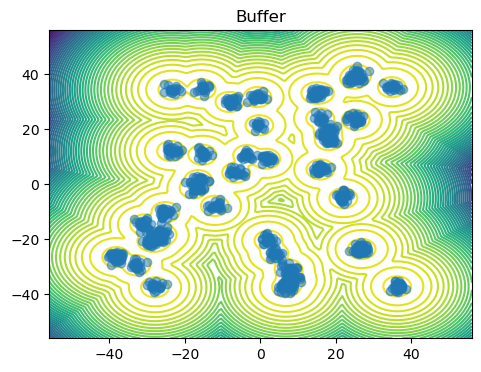

In [ ]:
fig=gmm_dist.get_dataset_fig(inital_samples)

ultra long langevin MCMC

100%|██████████| 50000/50000 [09:20<00:00, 89.28it/s] 


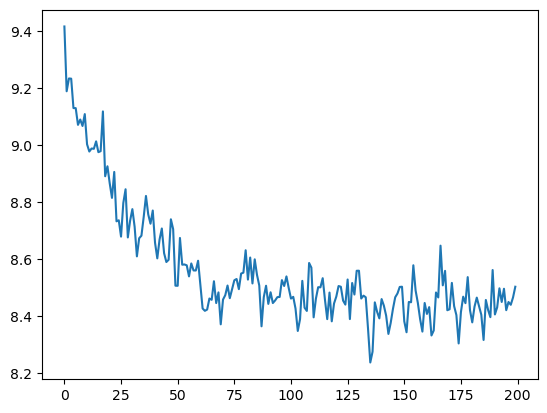

In [18]:
true_samples=gmm_dist.gmm.sample((1000,))
inital_samples=(torch.rand_like(true_samples)*2-1)*45
true_samples=true_samples.unsqueeze(1)
std=1.5
step_size=1
w2_list=[]
new_samples=inital_samples
new_samples=new_samples.requires_grad_(True)
for i in tqdm.tqdm(range(50000)):
    new_samples_energies=gmm_dist(new_samples)
    energy_grads=torch.autograd.grad(new_samples_energies.sum(),new_samples)[0]
    with torch.no_grad():
            new_new_samples_given_new_samples_mean=new_samples + ((std**2)/2)*energy_grads*step_size
            new_new_samples_given_new_samples_noise=torch.randn_like(inital_samples)*std*(step_size**0.5)
            new_new_samples=new_new_samples_given_new_samples_mean+new_new_samples_given_new_samples_noise
    new_new_samples=new_new_samples.requires_grad_(True)
    new_new_samples_energies=gmm_dist(new_new_samples)
    energy_grads=torch.autograd.grad(new_new_samples_energies.sum(),new_new_samples)[0]
    with torch.no_grad():
        new_samples_given_new_new_samples_mean=new_new_samples + ((std**2)/2)*energy_grads*step_size
    logprob_new_new_samples_given_new_samples=MultivariateNormal(new_new_samples_given_new_samples_mean,(std**2)*torch.eye(new_new_samples.shape[-1])*step_size).log_prob(new_new_samples)
    logprob_new_samples_given_new_new_samples=MultivariateNormal(new_samples_given_new_new_samples_mean,(std**2)*torch.eye(new_new_samples.shape[-1])*step_size).log_prob(new_samples)
    acceptances=torch.exp(new_new_samples_energies - new_samples_energies + logprob_new_samples_given_new_new_samples - logprob_new_new_samples_given_new_samples)>torch.rand_like(new_samples_energies)
    with torch.no_grad():
        new_samples[acceptances]=new_new_samples[acceptances]
        #new_samples=new_new_samples
    if i%250==0:
        current_samples=new_samples.unsqueeze(1)
        metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
        w2=metrics[1][1]
        w2_list.append(w2)
    new_samples=new_samples.requires_grad_(True)
plt.plot(w2_list)

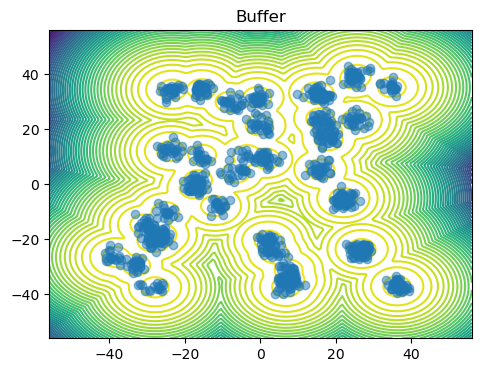

In [ ]:
fig=gmm_dist.get_dataset_fig(new_samples)

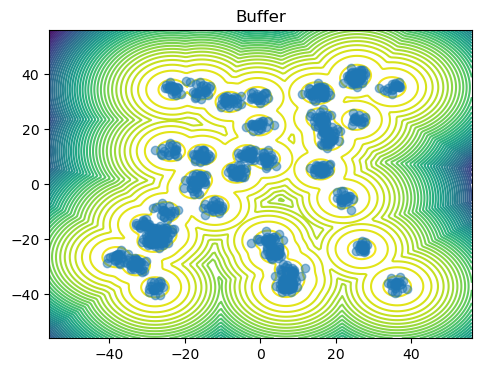

In [ ]:
fig=gmm_dist.get_dataset_fig(true_samples[:,0,:])

In [ ]:
current_samples=new_samples.unsqueeze(1)
print(current_samples.shape)
metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
w2=metrics[1][1]
print('w2',w2)

torch.Size([1000, 1, 2])
w2 8.757981079578062


In [23]:
# Leapfrog integrator for simulating Hamiltonian dynamics
def leapfrog(x, r, logp, steps, step_size):
    grad_state = x.requires_grad
    x.requires_grad_(True)
    x.retain_grad()
    if x.grad is not None:
        x.grad.zero_()
    p = logp(x).sum()
    p.backward()
    r += 0.5 * step_size * x.grad # half step update for momentum
    for _ in range(steps):
        with torch.no_grad():
            x += step_size * r # full step update of position
        x.grad.zero_()
        p = logp(x).sum()
        p.backward()
        r += step_size * x.grad # full update of momentum
    r -= 0.5 * step_size * x.grad # correction - half step in backward direction
    x.requires_grad_(grad_state)
    return x, r

In [24]:
# Hamiltonion Monte Carlo Algorithm
def hmc(x, true_samples,logp, steps, leapfrog_steps, step_size, return_traj = False):
    if return_traj:
        traj = []
    w2_list=[]
    for i in tqdm.tqdm(range(steps)):
        r = torch.randn_like(x)
        h = - logp(x) + 0.5 * (r ** 2).sum(-1)
        # print(f"{logp(x).sum().item():8e}, {P_noise.log_prob(x).sum().item():8e}") #, end = '\033[K\r')
        new_x = x.detach().clone()
        new_x, r = leapfrog(new_x, r, logp, leapfrog_steps, step_size)
        new_h = - logp(new_x) + 0.5 * (r ** 2).sum(-1)
        accept = torch.exp(torch.min(torch.zeros_like(h), h - new_h))
        accept_pos = torch.where(torch.rand_like(accept) < accept)[0]
        with torch.no_grad():
            x[accept_pos] = new_x[accept_pos]
        if return_traj:
            traj.append(x.detach().clone())
        if i%250==0:
            current_samples=x.unsqueeze(1)
            metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
            w2=metrics[1][1]
            w2_list.append(w2)
    plt.plot(w2_list)
    
    if return_traj:
        return x, traj
    else:
        return x

  0%|          | 0/150000 [00:00<?, ?it/s]

100%|██████████| 150000/150000 [58:32<00:00, 42.71it/s] 


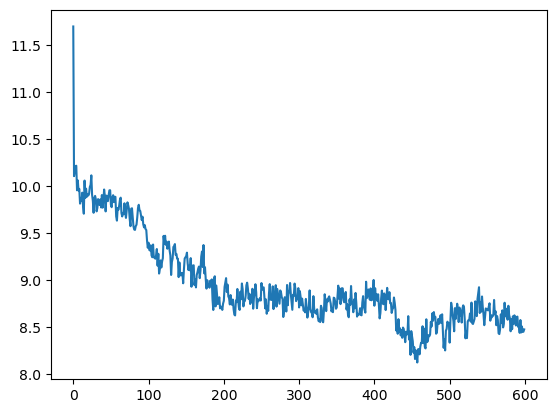

In [26]:
true_samples=gmm_dist.gmm.sample((1000,))
initial_samples=(torch.rand_like(true_samples)*2-1)*45
true_samples=true_samples.unsqueeze(1)
new_samples=hmc(initial_samples,true_samples,gmm_dist,150000,5,1)